<a href="https://colab.research.google.com/github/AntonioSanabria26/FisicaComputacional1/blob/master/Evaluacion1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **BIBLIOTECAS UTILIZADAS**

In [689]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf, pacf

import pandas.util.testing as tm

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

%matplotlib inline

# **DEPURANDO DATA FRAME**

In [690]:
#LECTURA DEL DATRA FRAME DE ANTARTIDA
URL = "https://raw.githubusercontent.com/carloslizarragac/FisicaComputacional1/master/Eval1/data/co2_spo_DailyData.txt"
df = pd.read_csv(URL, encoding='cp1251', sep='\s+', header=None, skiprows=150, skipfooter=1, engine='python')

#BORRANDO PRIMERA FILA
df = df.drop(0,axis=0)

#CONVIRTIENDO FECHA A FORMATO DATE, Y PONIENDOLA COMO INDEX
df["Fecha"] = df[3].map(str) + "/" + df[2]+"/"+ df[1]
df["Fecha"] = pd.to_datetime(df["Fecha"],dayfirst=True,errors ='coerce')
df["Año"] = df["Fecha"].dt.year
df["Mes"] =df["Fecha"].dt.month
df["Día"] =df["Fecha"].dt.day
df = df.set_index("Fecha")


#COLUMNAS QUE NO SE VAN A UTILIZAR
df = df.drop(range(0, 8),axis=1)
df = df.drop(range(9, 17),axis=1)

#CONVIRTIENDO A FLOTANTE
df[8] = df[8].astype(float)

#REMPLAZANDO -999.99 A NaN
df = df.replace(to_replace= -999.99 ,value = np.nan,regex= True )

#RENOMBRANDO COLUMNAS
df.columns = ["Value","Año","Mes","Dia"]

#CONSTRUCCION DEL DATA FRAME DE ENTRE LOS AÑOS 1980 A 2019
df2 = df[(df['Año'] >= 1981) & (df['Año'] < 2019)].copy()
df2.ffill(axis = 0 , inplace= True) 

df2.head(300)



,Value,Año,Mes,Dia
Fecha,,,,
1981-01-01,338.03,1981,1,1
1981-01-02,338.07,1981,1,2
1981-01-03,338.12,1981,1,3
1981-01-04,338.06,1981,1,4
1981-01-05,338.05,1981,1,5
...,...,...,...,...
1981-10-23,339.15,1981,10,23
1981-10-24,339.13,1981,10,24
1981-10-25,339.14,1981,10,25


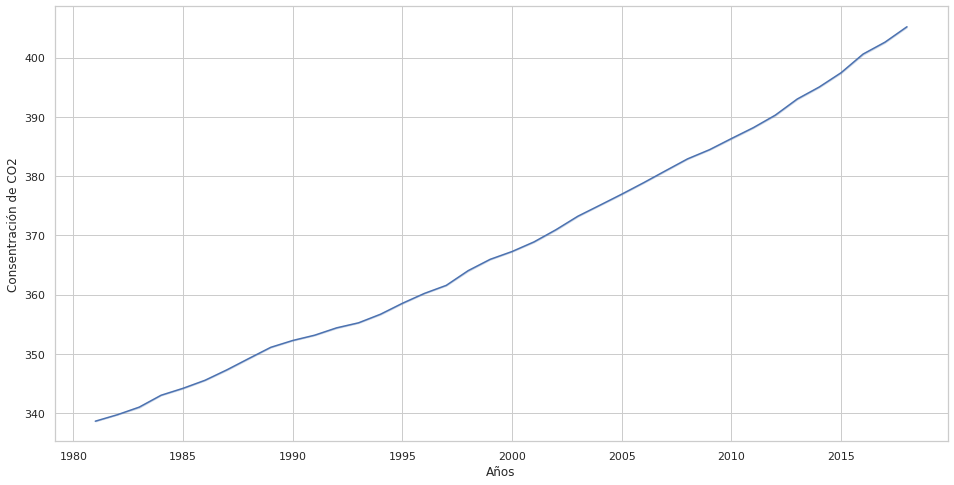

In [691]:
# GRAFICA DE CONSENTRACIÓN DE CO2
sns.set_style('whitegrid')
plt.figure(figsize=(16,8))

sns.lineplot(x='Año', y='Value', data=df2);

plt.xlabel('Años')
plt.ylabel('Consentración de CO2')

plt.show()

# **PRUEBA AVANZADA DE Dickey-Fuller**

In [692]:
#PRUEBA AVANZADA DE DICKEY-FULLER

def test_stationarity(df_ts):

#SE DETERMIAN LA ESTADISTICA DE LOS PROMEDIOS MOVILES
    rolmean = df_ts.rolling(window=365, center=True,min_periods=1).mean()
    rolstd = df_ts.rolling(window=365, center=True,min_periods=1).std() 
    
#SE DEFINE EL TAMAÑO DE LA FIGURA
    plt.rcParams["figure.figsize"] = (12,6)

#GRAFICAMOS LA ESTADISTICA MOVIL
    plt.plot(df_ts, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std Deviation')
 
    #plt.legend(loc='best')
    plt.title('Promedio Móvil y Desviación Estándar')
    plt.grid()
    plt.show()
 
#REALIZACION DE LA PRUEBA AUMENTADA DICKEY-FULLER
    print('Resultados de la Prueba de Dickey-Fuller:')
    dftest = adfuller(df_ts, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], 
                         index=['Test Statistic','p-value',
                                '#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [693]:
# DEFINIMOS LA SERIE DE TIEMPO PARA Value QUE VAMOS A ESTUDIAR.

df2_test = df2['Value'].copy()
df2_test



Fecha
1981-01-01    338.03
1981-01-02    338.07
1981-01-03    338.12
1981-01-04    338.06
1981-01-05    338.05
               ...  
2018-12-27    406.47
2018-12-28    406.42
2018-12-29    406.31
2018-12-30    406.36
2018-12-31    406.28
Name: Value, Length: 13879, dtype: float64

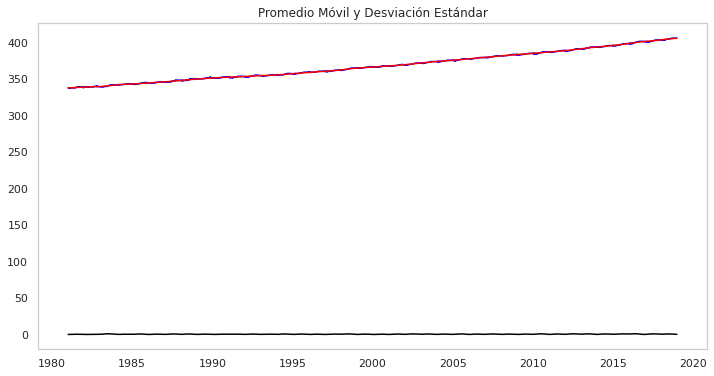

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                     1.167436
p-value                            0.995753
#Lags Used                        42.000000
Number of Observations Used    13836.000000
Critical Value (1%)               -3.430823
Critical Value (5%)               -2.861749
Critical Value (10%)              -2.566881
dtype: float64


In [694]:
#PRUEBA DE ESTACIONARIDAD DE Value
test_stationarity(df2_test)

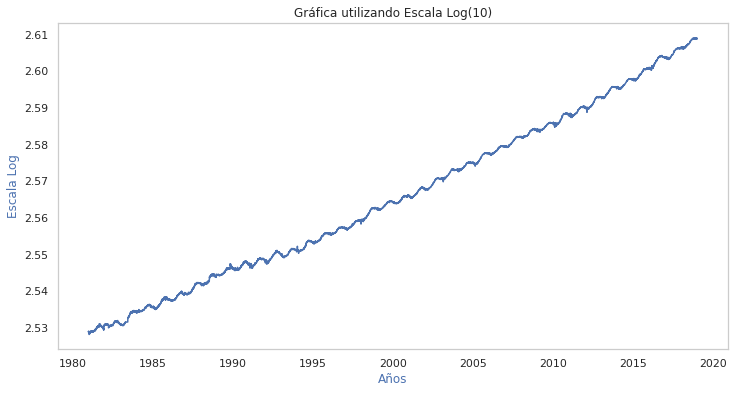

In [695]:
# UTILIZAMOS LOGARITMO
ts_test_log = np.log10(df2_test)
plt.plot(ts_test_log)
plt.xlabel('Años',color='b')
plt.ylabel('Escala Log',color='b')
plt.title('Gráfica utilizando Escala Log(10)')
plt.grid()
plt.show();

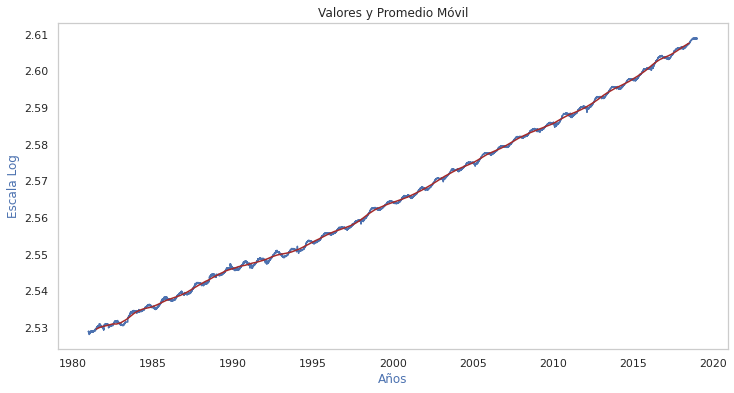

In [696]:
# VAMOS A CALCULAR EL PROMEDIO MOVIL DE ts_test_log CON VENTANA DE 365
# PARA VER EL CONTRASTE CON LA DE ARRIBA.

moving_avg = ts_test_log.rolling(365, center=True).mean()
plt.plot(ts_test_log)
plt.plot(moving_avg, color = 'brown')
plt.xlabel('Años',color='b')
plt.ylabel('Escala Log',color='b')
plt.title('Valores y Promedio Móvil')
plt.grid()
plt.show();

In [697]:
ts_test_log_moving_ave_diff = ts_test_log - moving_avg 
ts_test_log_moving_ave_diff.head()

Fecha
1981-01-01   NaN
1981-01-02   NaN
1981-01-03   NaN
1981-01-04   NaN
1981-01-05   NaN
Name: Value, dtype: float64

In [698]:
ts_test_log_moving_ave_diff.dropna(inplace=True)
ts_test_log_moving_ave_diff.head()

Fecha
1981-07-02    0.000081
1981-07-03    0.000076
1981-07-04    0.000084
1981-07-05    0.000207
1981-07-06    0.000176
Name: Value, dtype: float64

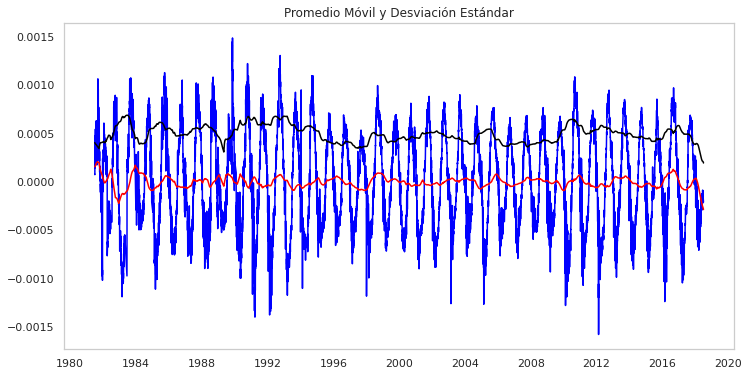

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -1.065544e+01
p-value                        4.546999e-19
#Lags Used                     4.000000e+01
Number of Observations Used    1.347400e+04
Critical Value (1%)           -3.430835e+00
Critical Value (5%)           -2.861755e+00
Critical Value (10%)          -2.566884e+00
dtype: float64


In [699]:
#AHORA LA ESTACIONARIDAD ESTARA ESCALADA EN LOG
test_stationarity(ts_test_log_moving_ave_diff)

In [700]:
#COMO VEMOS YA SE VOLVIO ESTACIONARIA CON EL METODO DE LOGARITMO

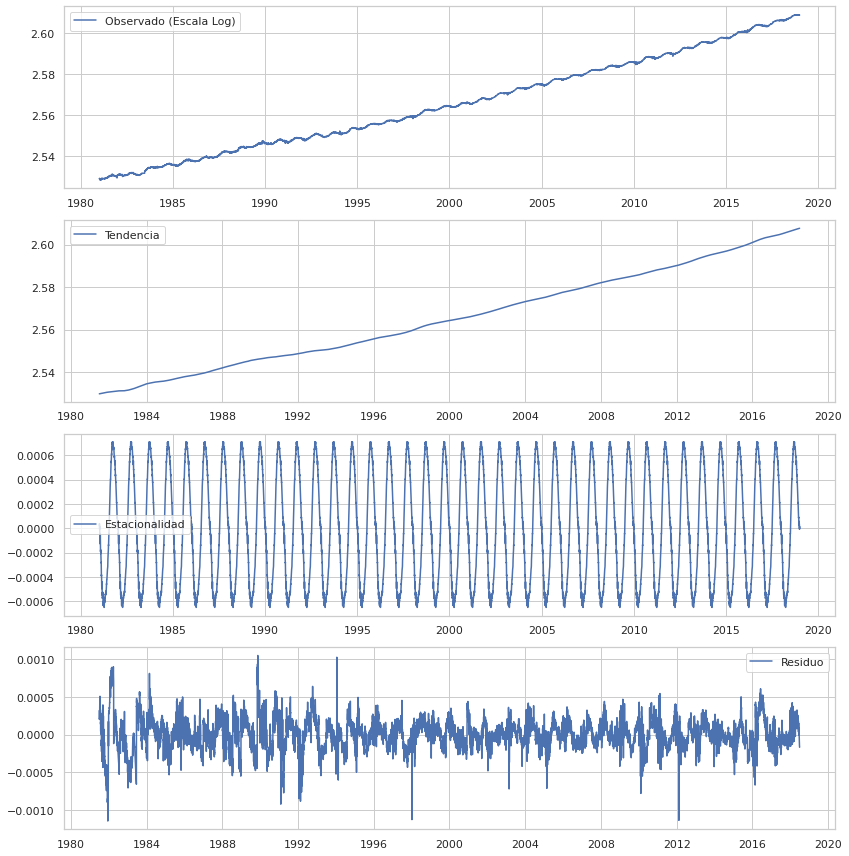

In [701]:
# Método de descomposición usando la biblioteca statsmodels.tsa

des = sm.tsa.seasonal_decompose(ts_test_log.interpolate(), model='additive', freq=365)

# La función regresa 3 componentes: tendencia, estacionalidad y un residuo

trend = des.trend
seasonal = des.seasonal
residue = des.resid

# Graficamos las componentes
plt.rcParams["figure.figsize"] = (12,12)
plt.subplot(411)
plt.plot(ts_test_log, label='Observado (Escala Log)')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Tendencia')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal, label='Estacionalidad')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residue, label='Residuo')
plt.legend(loc='best')

plt.tight_layout();

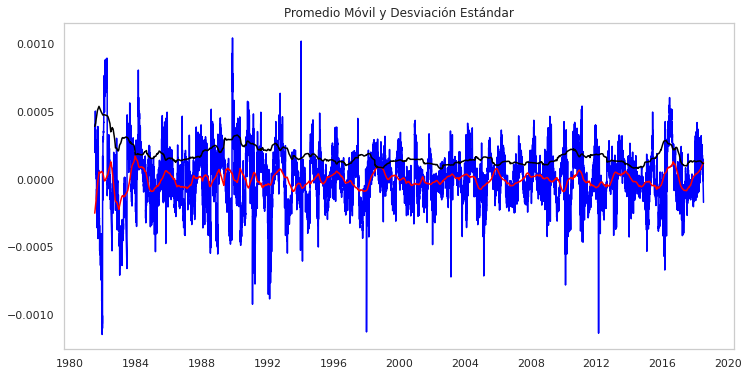

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -1.102900e+01
p-value                        5.731134e-20
#Lags Used                     2.800000e+01
Number of Observations Used    1.348600e+04
Critical Value (1%)           -3.430835e+00
Critical Value (5%)           -2.861754e+00
Critical Value (10%)          -2.566884e+00
dtype: float64


In [702]:
# Eliminando la Tendencia y Estacionalidad, probamos si la serie Residuo es estacionaria o no...

ts_test_log_decompose = residue 
ts_test_log_decompose.dropna(inplace=True)
test_stationarity(ts_test_log_decompose)

In [703]:
#COMO SE PUEDE VER EL RESIDUO TAMBIEN ES ESTACIONARIA

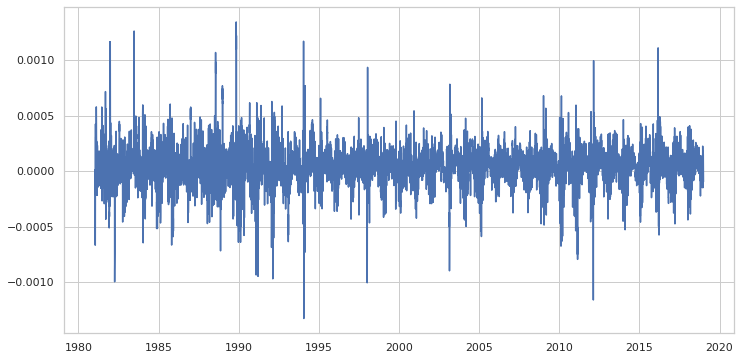

In [704]:
# Diferenciamos usando la función df.shift()
ts_test_log_diff = ts_test_log - ts_test_log.shift(periods=7)
plt.plot(ts_test_log_diff);

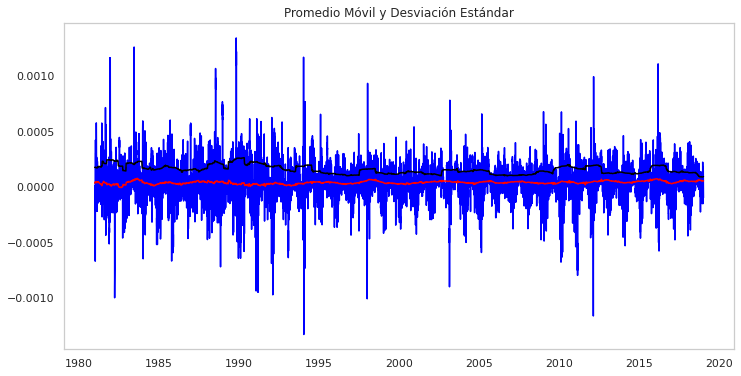

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -1.142571e+01
p-value                        6.703736e-21
#Lags Used                     4.200000e+01
Number of Observations Used    1.382900e+04
Critical Value (1%)           -3.430823e+00
Critical Value (5%)           -2.861749e+00
Critical Value (10%)          -2.566881e+00
dtype: float64


In [705]:
ts_test_log_diff.dropna(inplace=True)
test_stationarity(ts_test_log_diff)

In [706]:
#TAMBIEN ES ESTACIONARIA

# **PROMEDIO MOVIL**

In [707]:
# SUAVIZANDO CURVA DE TMAX CON PROMEDIOS MOVILES (7,30, 365 DÍAS)

df_90_7d = ts_test_log.rolling(7, center=True,min_periods=1).mean()
df_90_30d = ts_test_log.rolling(30, center=True,min_periods=1).mean()
df_90_365d = ts_test_log.rolling(365, center=True,min_periods=1).mean()

df_90_365d

Fecha
1981-01-01    2.529075
1981-01-02    2.529079
1981-01-03    2.529083
1981-01-04    2.529088
1981-01-05    2.529092
                ...   
2018-12-27    2.608606
2018-12-28    2.608612
2018-12-29    2.608618
2018-12-30    2.608624
2018-12-31    2.608630
Name: Value, Length: 13879, dtype: float64

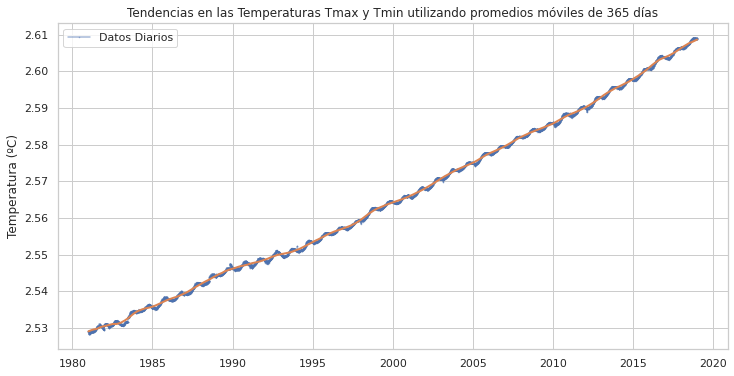

In [708]:
# Graficas de promedios móviles de 365 días para Value  

fig, ax = plt.subplots()
ax.plot(ts_test_log, marker='.', markersize=1, linestyle='-', alpha=0.5, label='Datos Diarios')
ax.plot(df_90_365d, linewidth=2)
    
ax.legend()
ax.set_ylabel('Temperatura (ºC)')
ax.set_title('Tendencias en las Temperaturas Tmax y Tmin utilizando promedios móviles de 365 días');

# **METODO ARIMA**

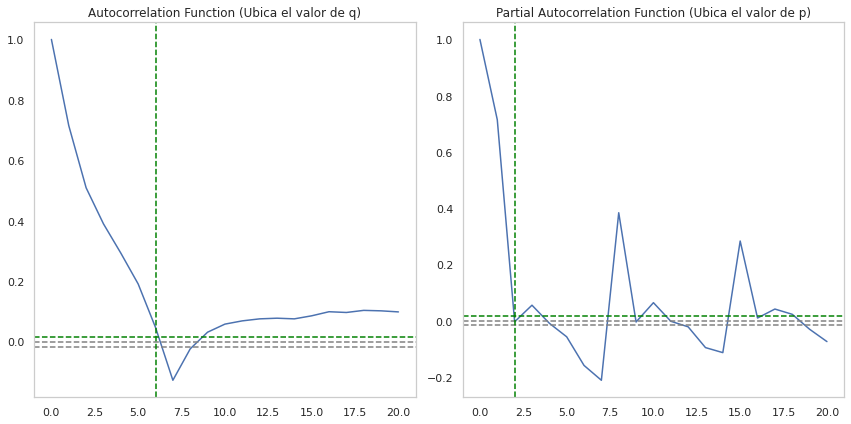

In [709]:
#Aplicamos ARIMA

lag_acf = acf(ts_test_log_diff, nlags=20)
lag_pacf = pacf(ts_test_log_diff, nlags=20, method = 'ols')

# Tamaño de las gráficas
plt.rcParams["figure.figsize"] = (12,6)

# Gráfica de ACF (Autocorrelation Function)
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='green')

# Graficamos unas líneas verticales como referencias
plt.axvline(x=6, linestyle='--', color='green')
plt.grid()
plt.title('Autocorrelation Function (Ubica el valor de q)')

# Gráfica de PACF (Partial Autocorrelation Function)
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='green')
# Graficamos unas líneas verticales como referencias 
plt.axvline(x=2, linestyle='--', color='green')
plt.grid()
plt.title('Partial Autocorrelation Function (Ubica el valor de p)')

plt.tight_layout()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                D.Value   No. Observations:                13871
Model:                 ARIMA(2, 1, 0)   Log Likelihood              105612.066
Method:                       css-mle   S.D. of innovations              0.000
Date:                Wed, 24 Feb 2021   AIC                        -211216.132
Time:                        23:43:59   BIC                        -211185.981
Sample:                    01-09-1981   HQIC                       -211206.090
                         - 12-31-2018                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const          3.217e-09   7.58e-07      0.004      0.997   -1.48e-06    1.49e-06
ar.L1.D.Value    -0.1640      0.008    -19.614      0.000      -0.180      -0.148
ar.L2.D.Value    -0.1741      0.008    -

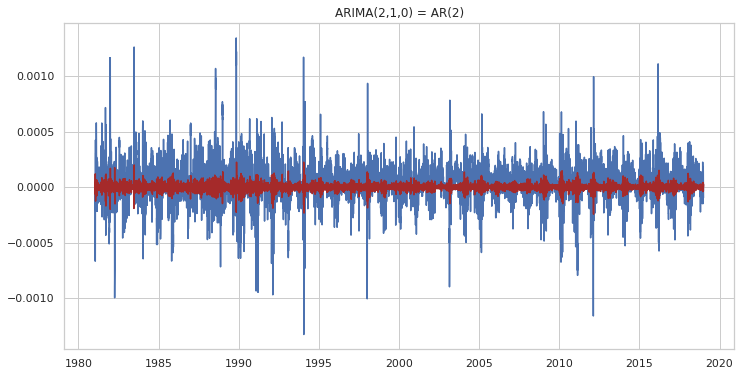

In [710]:
# MODELO AR ( AUTO-REGRESION )
# Modelo AR(p): (p,d,q) = (2,1,0) 
model = ARIMA(ts_test_log_diff, order=(2,1,0), missing='drop')
results_AR = model.fit(displ=-1)
plt.plot(ts_test_log_diff)
plt.plot(results_AR.fittedvalues, color='brown')
plt.title('ARIMA(2,1,0) = AR(2)')
print(results_AR.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


                             ARIMA Model Results                              
Dep. Variable:                D.Value   No. Observations:                13871
Model:                 ARIMA(0, 1, 6)   Log Likelihood              105485.883
Method:                       css-mle   S.D. of innovations              0.000
Date:                Wed, 24 Feb 2021   AIC                        -210955.766
Time:                        23:44:03   BIC                        -210895.466
Sample:                    01-09-1981   HQIC                       -210935.682
                         - 12-31-2018                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const          1.402e-09    6.7e-07      0.002      0.998   -1.31e-06    1.31e-06
ma.L1.D.Value    -0.1856      0.023     -8.178      0.000      -0.230      -0.141
ma.L2.D.Value    -0.1900      0.041     

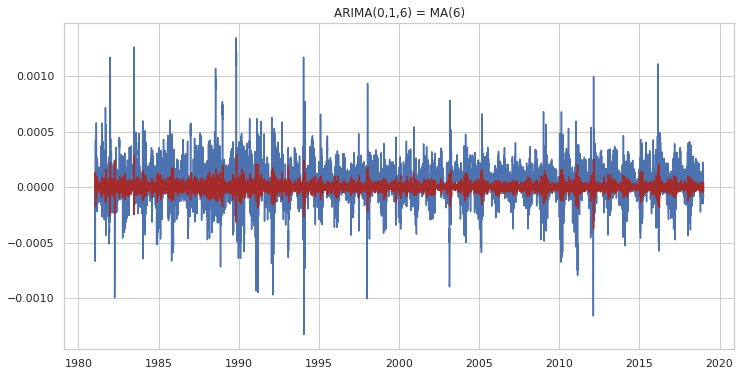

In [711]:
# MODELO MA ( PROMEDIO MOVIL )
# Modelo MA(q): (p,d,q) = (0,1,6) 
model = ARIMA(ts_test_log_diff, order=(0,1,6), missing='drop')
results_MA = model.fit(displ=-1)
plt.plot(ts_test_log_diff)
plt.plot(results_MA.fittedvalues, color='brown')
plt.title('ARIMA(0,1,6) = MA(6)')
print(results_MA.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:1441: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(-inv(hess)))


                             ARIMA Model Results                              
Dep. Variable:                D.Value   No. Observations:                13871
Model:                 ARIMA(2, 1, 6)   Log Likelihood              105769.538
Method:                       css-mle   S.D. of innovations              0.000
Date:                Wed, 24 Feb 2021   AIC                        -211519.076
Time:                        23:44:14   BIC                        -211443.701
Sample:                    01-09-1981   HQIC                       -211493.971
                         - 12-31-2018                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const          4.223e-09   5.15e-07      0.008      0.993      -1e-06    1.01e-06
ar.L1.D.Value    -0.1643        nan        nan        nan         nan         nan
ar.L2.D.Value    -0.1534        nan     

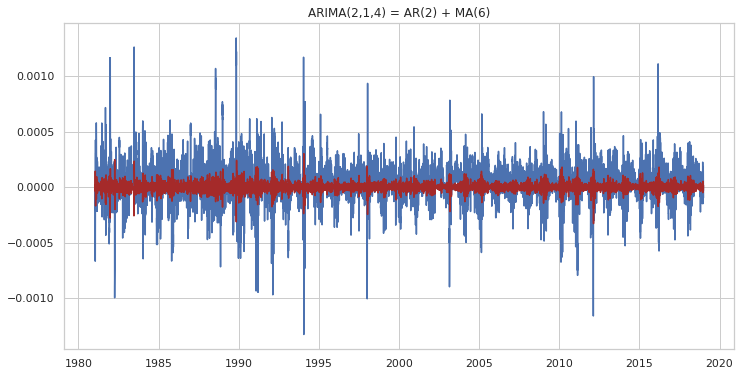

In [712]:
# MODELO DE ARIMA (AUTO-REGRESION + PROMEDIO MOVIL)
# Modelo ARIMA(p): (p,d,q) = (2,1,6) 
model = ARIMA(ts_test_log_diff, order=(2,1,6), missing='drop')
results_ARIMA = model.fit(displ=-1)
plt.plot(ts_test_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='brown')
plt.title('ARIMA(2,1,4) = AR(2) + MA(6)')
print(results_ARIMA.summary())

In [713]:
# AIC PARA EL MODELO AR    =                          -211216.132
# AIC PARA EL MODELO AM    =                          -210955.766
# AIC PARA EL MODELO ARIMA =                          -211519.076

# Podemos afirmar que ARIMA (2,1,6) es el mejor modelo de los 3 que exploramos.
# YA QUE EL AIC ES EL MENOR.


In [714]:
# Definimos una serie de tiempo con las predicciones obtenidas por el método ARIMA
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff)

Fecha
1981-01-09    4.223467e-09
1981-01-10    1.761241e-06
1981-01-11    1.496000e-05
1981-01-12   -3.882883e-06
1981-01-13   -2.508344e-05
                  ...     
2018-12-27   -3.370102e-05
2018-12-28   -2.700328e-05
2018-12-29    1.264493e-05
2018-12-30    1.352670e-05
2018-12-31    1.556952e-05
Length: 13871, dtype: float64


In [715]:
# Le sumamos las predicciones de ARIMA a la serie observada (ts_test_log_diff)
predictions_ARIMA_log = pd.Series(ts_test_log_diff, index = ts_test_log_diff.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff)
print(predictions_ARIMA_log.head())
print(predictions_ARIMA_log.tail())

Fecha
1981-01-08         NaN
1981-01-09   -0.000128
1981-01-10   -0.000204
1981-01-11   -0.000075
1981-01-12   -0.000042
dtype: float64
Fecha
2018-12-27    0.000073
2018-12-28   -0.000048
2018-12-29    0.000034
2018-12-30   -0.000040
2018-12-31   -0.000081
dtype: float64


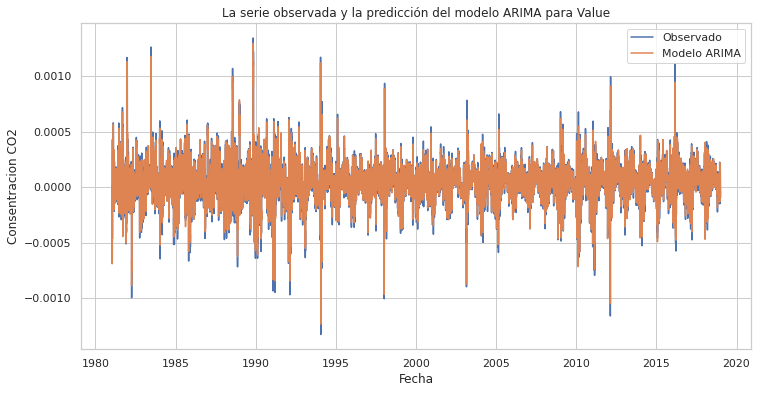

In [716]:
# Regresamos a la escala de Temperatura original 
predictions_ARIMA = 10**(predictions_ARIMA_log)
# Graficamos la serie original y las predicciones con ARIMA

# Tamaño de las gráficas
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(ts_test_log_diff, label='Observado');
plt.plot(predictions_ARIMA_log, label='Modelo ARIMA');
plt.xlabel('Fecha')
plt.ylabel('Consentracion CO2')
plt.title('La serie observada y la predicción del modelo ARIMA para Value')
plt.legend(loc='best');

In [717]:
# Calculamos el RMSE (Root Mean Square Error - Error de la Raiz Cuadrada de la Media)

RMSE = np.sqrt(np.mean((predictions_ARIMA_log - ts_test_log_diff)**2))
print('RMSE:', RMSE)

RMSE: 3.384962603265863e-05


In [718]:
#UN ERROR SUPER PEQUEÑO

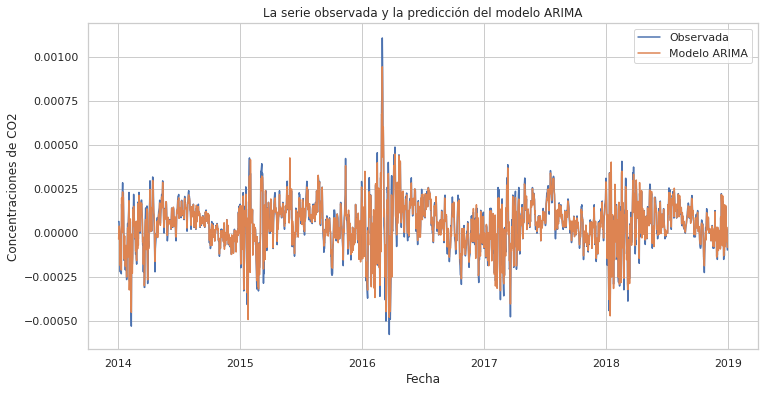

In [719]:
# Graficamos sólo los útimos datos de las series 
ts_test_last = ts_test_log_diff.tail(1825)
predictions_ARIMA_last = predictions_ARIMA_log.tail(1825)
plt.plot(ts_test_last, label='Observada');
plt.plot(predictions_ARIMA_last, label='Modelo ARIMA');
plt.xlabel('Fecha')
plt.ylabel('Concentraciones de CO2')
plt.title('La serie observada y la predicción del modelo ARIMA')
plt.legend(loc='best');